In [165]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
from utils.utils import MyDataset, show_image, visualise_output
import sys
sys.path.append("..")
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from networks.ann_reward import ANN
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy
from torch.autograd import Variable 

In [2]:
dataset = MyDataset(root='../data/complete_random/homo_2/Sub20x20_full_grid_.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float))

In [285]:
latent_dims = 256
capacity_ = latent_dims//2
capacity = 256
input_size = 20
epochs = 100
sigmoid = False
net = FireAutoencoder(capacity_, input_size, latent_dims, sigmoid)
reward_ann = ANN(latent_dims, capacity)
net.load_state_dict(torch.load(f'weights/v1/homo_2_sub20x20_latent={latent_dims}_capacity={capacity_}_{epochs}_sigmoid={sigmoid}.pth', map_location=torch.device('cpu')))
reward_ann.load_state_dict(torch.load(f'weights/v1/ann_capacity={capacity}_50_sigmoid={sigmoid}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [286]:
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05])

In [287]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [288]:
all_images, all_r = next(iter(full_loader))

In [289]:
embeddings = net.encode(all_images)

In [290]:
with torch.no_grad():
    rewards = reward_ann(embeddings)

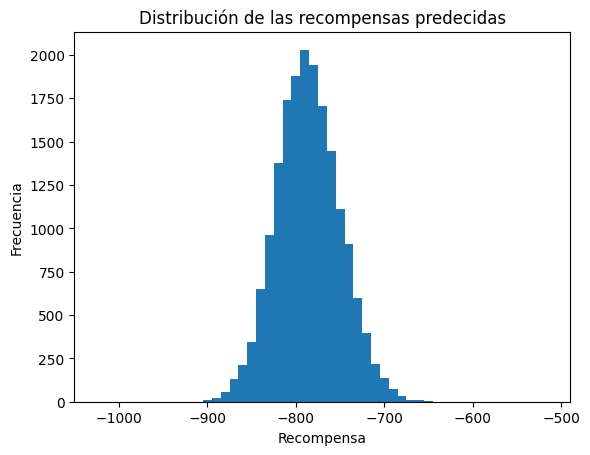

In [291]:
bins = np.arange(-1020, -500, 10)
plt.hist(rewards.squeeze().numpy(), bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
#plt.savefig(f"linear_regresion/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [292]:
minimum = Variable(torch.zeros(1, 256), requires_grad=True) 

In [293]:
optimizer = torch.optim.Adam([minimum], lr = 0.001)

In [294]:
for i in range(10000):
    my_single_scalar = -reward_ann(minimum[0])
    optimizer.zero_grad()
    my_single_scalar.backward()
    optimizer.step()

In [295]:
my_single_scalar

tensor([14.9128], grad_fn=<NegBackward0>)

In [296]:
net.float()

FireAutoencoder(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=6400, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=6400, bias=True)
  (conv1_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [297]:
solution = net.decode(minimum.float().unsqueeze(0))

In [298]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<0.5] = 0
else:
    solution[solution>0] = 1

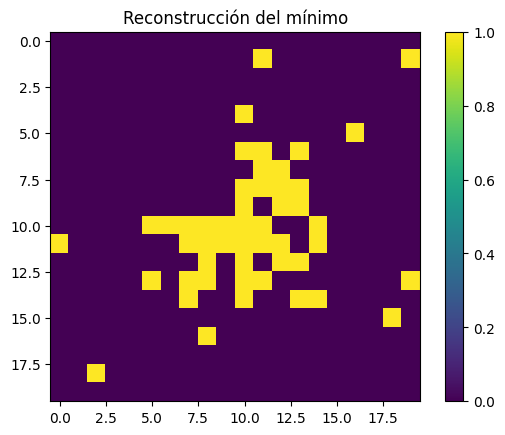

In [301]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        plt.colorbar()
        plt.savefig(f"ann/v1/minimum_decoding_{capacity}_{epochs}_sigmoid={sigmoid}.png")
        plt.show()

In [300]:
with torch.no_grad():
    print(repr(solution[0][0].numpy()))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.